# Harry Potter Image Classification

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import random
import os

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

assert torch.cuda.is_available() & torch.backends.cudnn.enabled

PATH = "data/harry_potter/"
PATH_TRAIN = PATH+'train/'
DOWNLOAD_FLAG = False  # Select false if we have already donwloaded the images + labels

if not os.path.exists(PATH_TRAIN):
    os.makedirs(PATH_TRAIN)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
if DOWNLOAD_FLAG:
    
    import download_img_list
    
    characters = ['Harry Potter', 'Lord Voldemort', 'Hermione Granger', 'Severus Snape',
                 'Albus Dumbledore', 'Draco Malfoy', 'Dobby the House Elf', 'Ron Weasley',
                 'Hagrid', 'Sirius Black']
        
    labels, err_list = download_img_list.download_img_list(characters, PATH_TRAIN, 100)
        
    labels.to_csv(PATH+'labels.csv', index = False)
    
    print('\nNot download: ')
    print(err_list)
else:
    labels = pd.read_csv(PATH+'labels.csv')

## Look at the downloaded Images

In [3]:
def showPics(name, labels = labels, dims = (2, 5), directory = PATH_TRAIN):
    '''Show images of a given president'''
    nrows, ncols = dims
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize =(ncols * 4, nrows * 4))
    fns = list(labels['id'][labels['label'] == name])
    k = 0
    for i in range(nrows):
        for j in range(ncols):
            axes[i, j].imshow(plt.imread(directory+fns[k]), cmap = 'gray')
            axes[i, j].set_title(fns[k])
            k = (k + 1) % (len(fns))

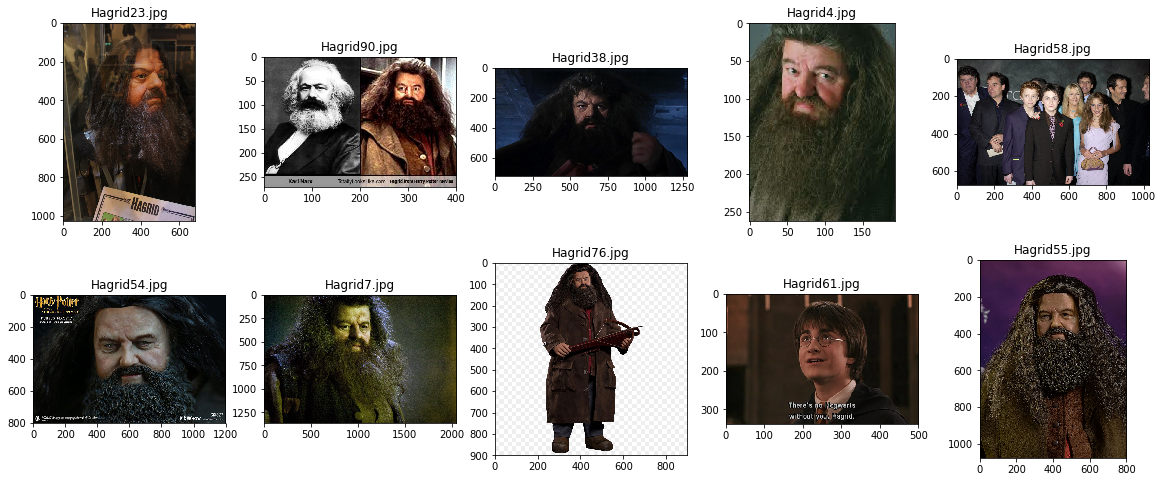

In [4]:
showPics('Hagrid')

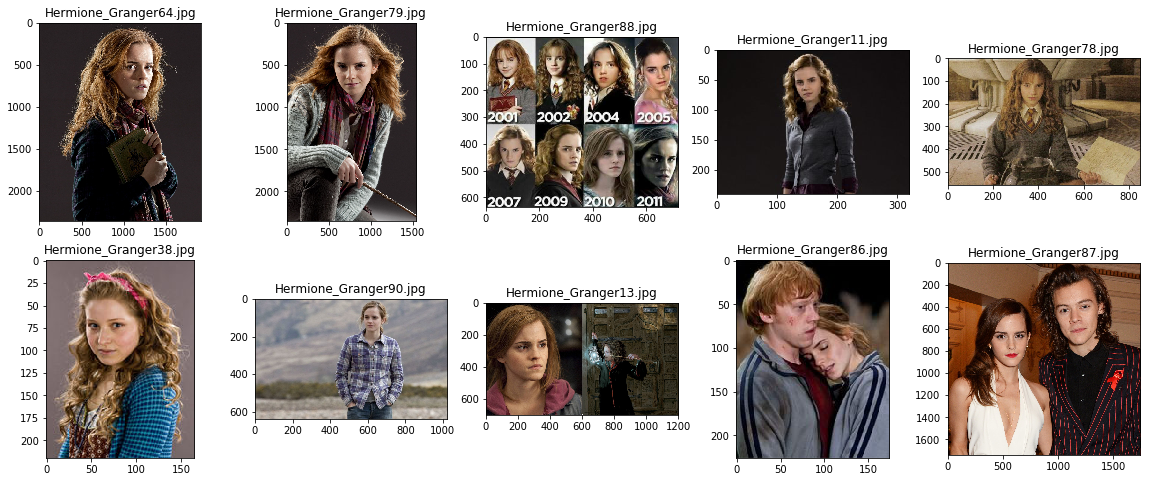

In [5]:
showPics('Hermione_Granger')

In [6]:
labels.groupby('label').size().sort_values().head(10)  # In case there are classes with few exmaples

label
Harry_Potter           90
Severus_Snape          92
Sirius_Black           93
Hagrid                 95
Hermione_Granger       95
Lord_Voldemort         96
Albus_Dumbledore       97
Draco_Malfoy           97
Ron_Weasley            97
Dobby_the_House_Elf    99
dtype: int64

## Initial Model

In [7]:
n = len(labels.index)
val_idxs = get_cv_idxs(n, seed = 101)
(n, len(val_idxs))

(951, 190)

In [8]:
def get_data(sz, bs = 32): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.2)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', val_idxs=val_idxs, 
                                        suffix='', tfms=tfms, bs=bs)
    return data if sz > 300 else data.resize(340, 'tmp')

In [9]:
# Let's start with small images
sz = 128
arch = resnet34
data = get_data(sz)
learn = ConvLearner.pretrained(arch, data, precompute=True)  # Start with precompute = True

In [10]:
learn.lr_find()

epoch      trn_loss   val_loss   accuracy                
    0      7.068417   1783.149584 0.189474  



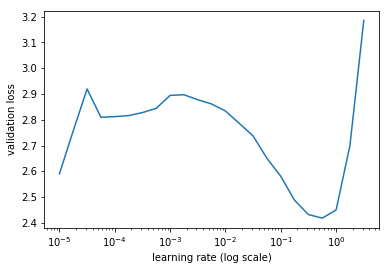

In [11]:
learn.sched.plot(0, 0)

In [12]:
lr = 1e-1

In [13]:
learn.fit(lr, 2)

epoch      trn_loss   val_loss   accuracy                
    0      2.287556   2.4419     0.510526  
    1      1.932615   2.081331   0.578947                



[array([2.08133]), 0.5789473728129738]

In [14]:
learn.precompute = False

In [15]:
learn.fit(lr, 3)

epoch      trn_loss   val_loss   accuracy                 
    0      1.746243   1.583842   0.631579  
    1      1.588977   1.582341   0.578947                 
    2      1.372807   1.42988    0.610526                 



[array([1.42988]), 0.6105263195539775]

In [16]:
learn.save('hp_v1')

## Increase Image size

In [17]:
#learn.load('hp_v1')

In [18]:
sz = 224

In [19]:
learn.set_data(get_data(sz))

In [20]:
learn.fit(lr, 1, cycle_len = 2)

epoch      trn_loss   val_loss   accuracy                 
    0      1.206154   1.022416   0.694737  
    1      1.013174   0.987413   0.710526                  



[array([0.98741]), 0.7105263189265603]

In [21]:
sz = 299
learn.set_data(get_data(sz))

In [22]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      1.05453    1.025421   0.7       
    1      0.980734   1.001192   0.736842                  
    2      0.93196    0.914902   0.752632                  



[array([0.9149]), 0.7526315776925337]

In [23]:
learn.save('hp_v2')

## Unfreeze Layers

In [24]:
#learn.load('hp_v2')

In [78]:
learn.unfreeze()

epoch      trn_loss   val_loss   accuracy                  
    0      3.816053   2.1802630416214126e+26 0.163158  



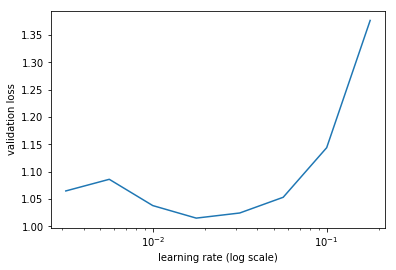

In [79]:
learn.lr_find()

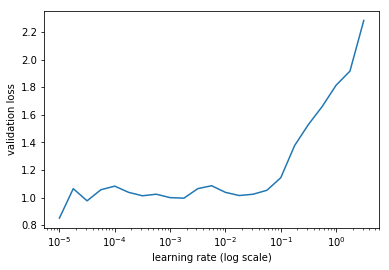

In [80]:
learn.sched.plot(0, 0)

In [81]:
lr = 1e-3 / 2
lrs = [lr, lr/5, lr/25]
lrs

[0.0005, 0.0001, 2e-05]

In [82]:
learn.fit(lrs, 1, cycle_len = 5)

epoch      trn_loss   val_loss   accuracy                  
    0      1.003574   0.925031   0.731579  
    1      0.948569   0.823946   0.768421                  
    2      0.904849   0.835244   0.773684                  
    3      0.848119   0.827813   0.768421                  
    4      0.805718   0.818721   0.768421                  



[array([0.81872]), 0.7684210513767443]

## Include TTA

In [83]:
log_preds, y = learn.TTA()

In [84]:
probs = np.mean(np.exp(log_preds), 0)

In [85]:
probs[:5, :5]

array([[0.06845, 0.00312, 0.09029, 0.00112, 0.11659],
       [0.00271, 0.04782, 0.06258, 0.02407, 0.42853],
       [0.00081, 0.00013, 0.00033, 0.00092, 0.84799],
       [0.00627, 0.00013, 0.01178, 0.00189, 0.83398],
       [0.00077, 0.00004, 0.00217, 0.00109, 0.92692]], dtype=float32)

In [86]:
preds = np.argmax(probs, 1)

In [87]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

cm

array([[14,  2,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 14,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 1,  0, 16,  0,  1,  0,  0,  0,  2,  0],
       [ 2,  0,  0, 20,  1,  0,  0,  0,  0,  0],
       [ 1,  0,  1,  0, 11,  0,  2,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 16,  0,  1,  1,  0],
       [ 0,  0,  1,  0,  0,  0, 26,  0,  2,  2],
       [ 0,  1,  1,  0,  1,  0,  0, 13,  1,  1],
       [ 0,  0,  1,  0,  0,  0,  0,  0, 15,  0],
       [ 0,  0,  0,  3,  3,  1,  0,  0,  1,  9]])

In [88]:
num_correct = (cm * np.eye(len(data.classes))).sum()
acc = num_correct / cm.sum()
acc

0.8105263157894737

In [89]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plots(ims, figsize=(12,6), rows=1, main_title = None, titles=None):
    f = plt.figure(figsize=figsize)
    plt.title(main_title)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def most_by_correct(cat, is_correct = True, num = 4): 
    mask = ((preds == data.val_y)==is_correct) & (data.val_y == cat)
    idxs = np.where(mask, )[0]
    mult = -1 if is_correct else 1
    return idxs[np.argsort(mult*probs[:, cat][idxs])[:num]]

def plot_val_with_title(cat, is_correct = True, title = '', num = 4):
    idxs = most_by_correct(cat, is_correct, num)
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[:, cat][x] for x in idxs]
    return plots(imgs, rows=1, titles=title_probs, main_title = title, figsize=(16,8)) 

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


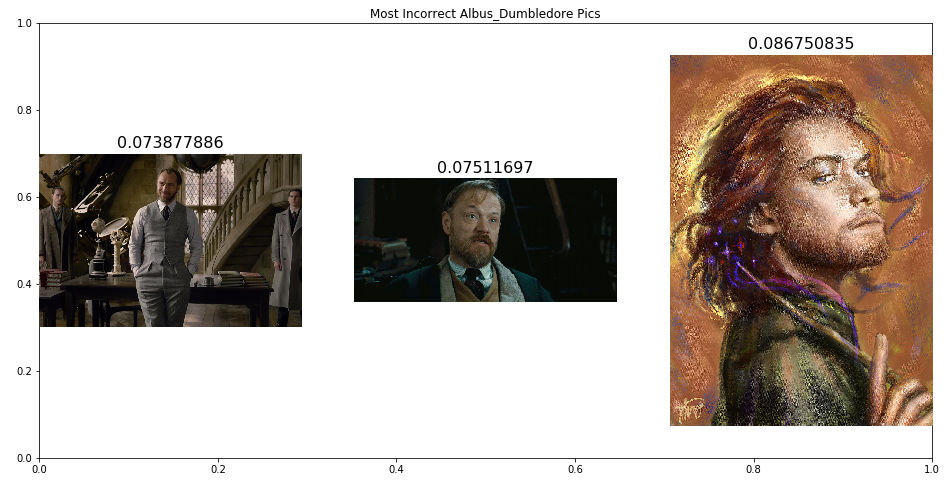

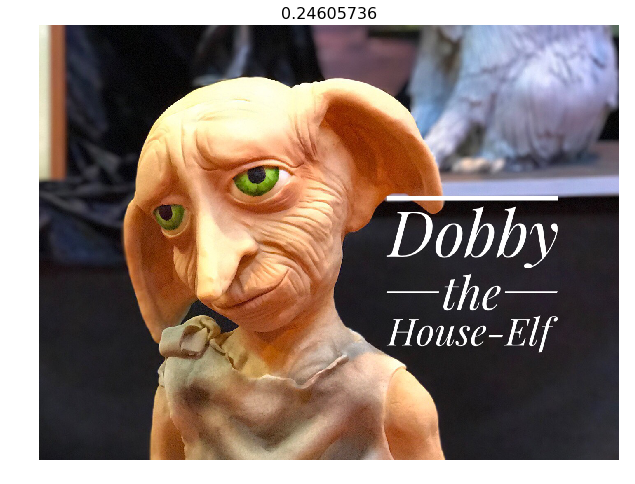

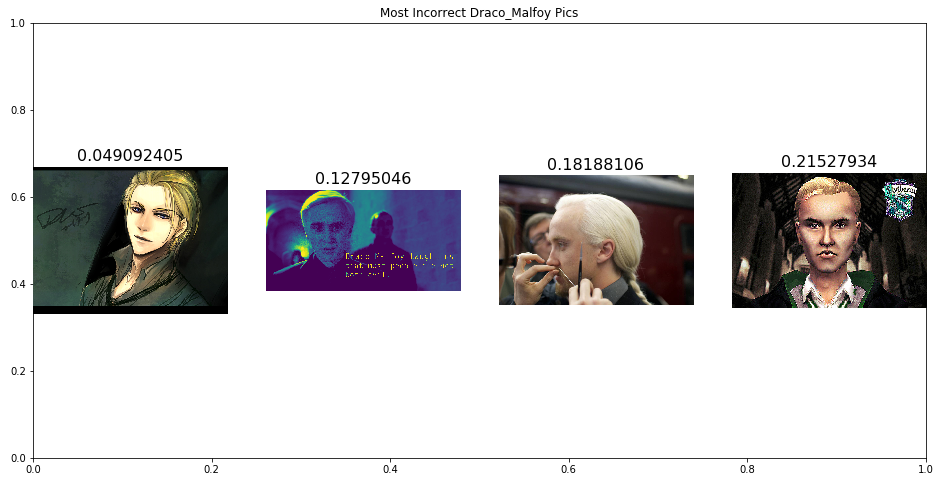

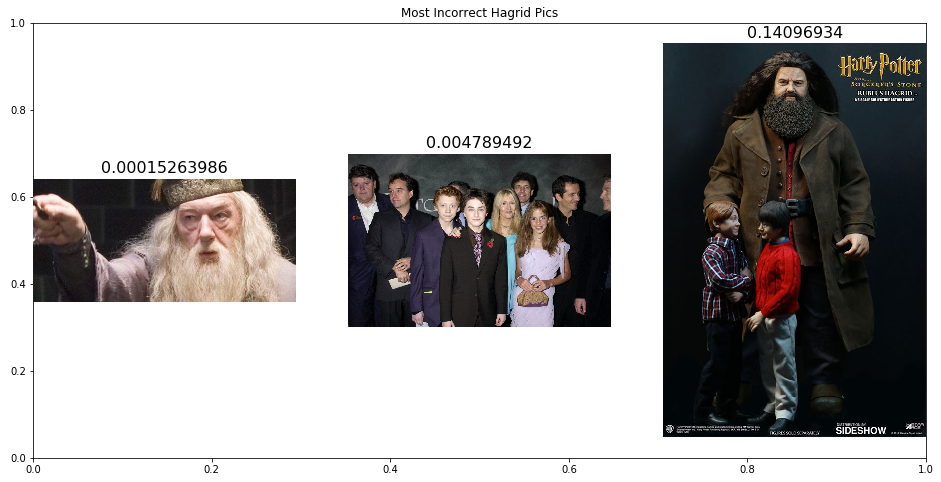

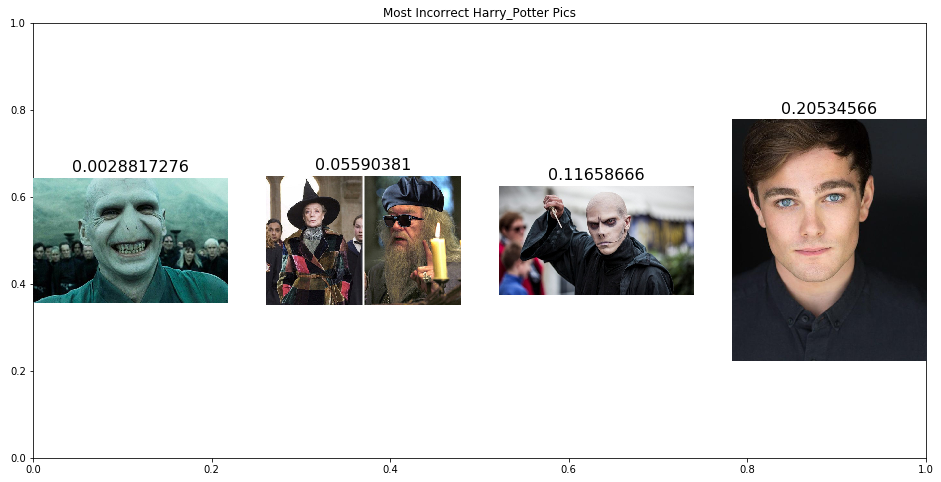

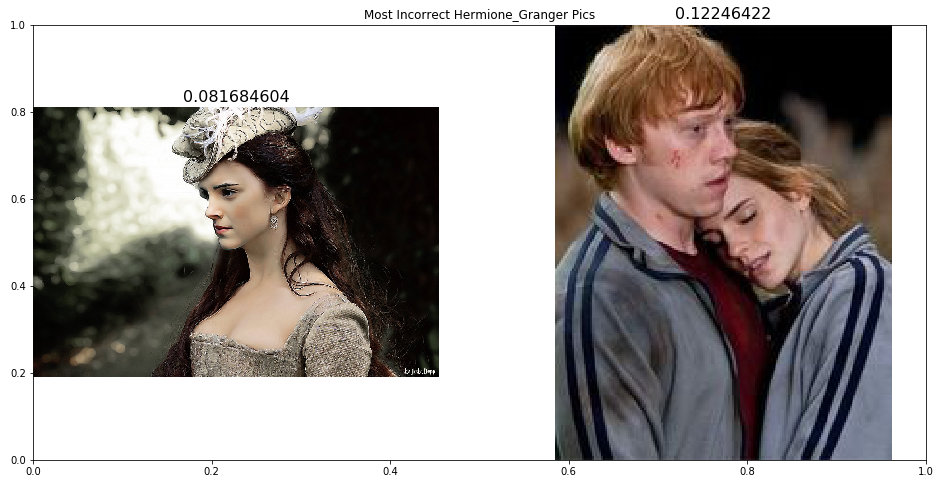

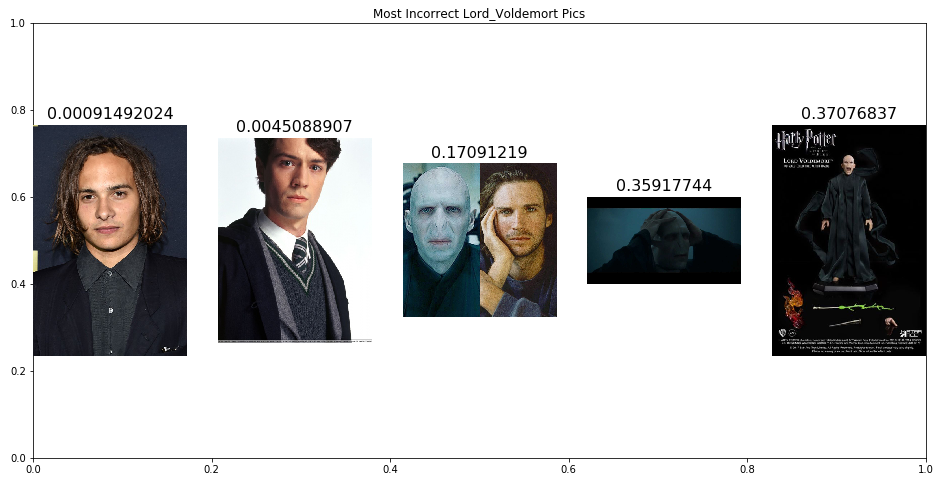

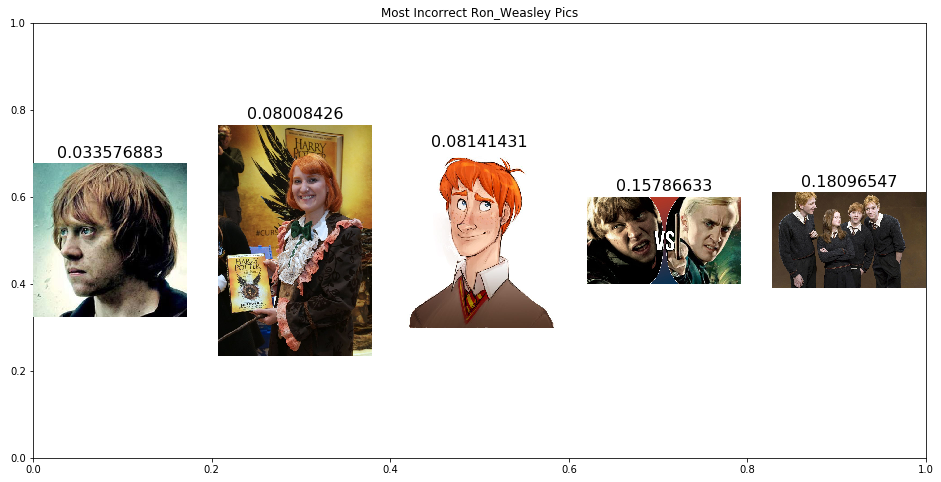

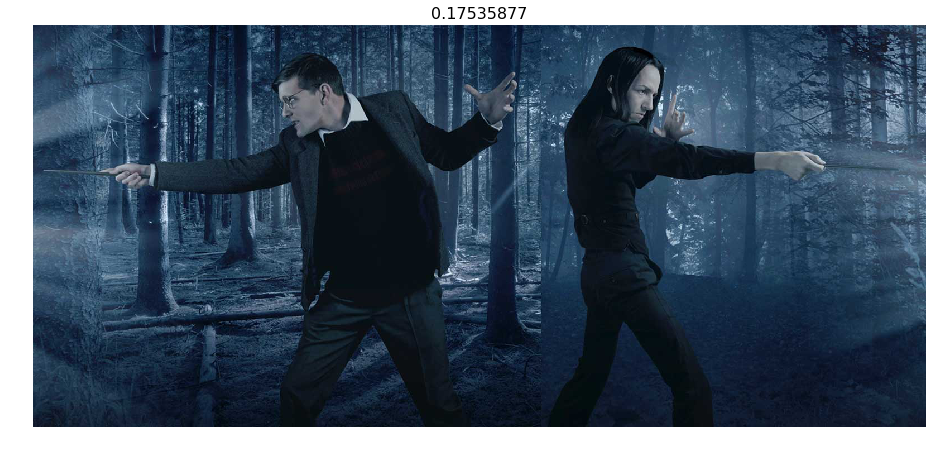

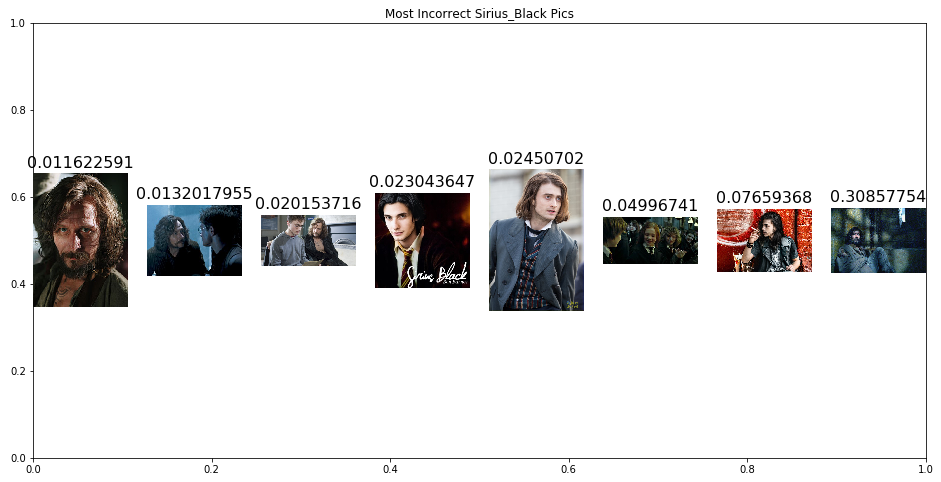

In [90]:
for i in range(len(data.classes)):
    num_inc = cm[i].sum()-cm[i][i]
    plot_val_with_title(i, False, 'Most Incorrect '+ data.classes[i]+' Pics', num = num_inc)

In [92]:
real_mis_class = 12
1 - real_mis_class / cm.sum()

0.9368421052631579